# Homework 4

In this homework we explore how we can leverage CUDA streams and asynchronous operations to maximize the throughput of matrix-vector multiplication. We build on the matrix-vector CUDA kernel we wrote last week namely the `ShuffleSingleWarpMultiplier` which assigns a single warp to each row and uses `__shfl_down_sync` to reduce the distributed multiplication.

We explore CUDA streams by varying the number of created streams and assigning an approximately equal number of rows to each stream.

All of the relevant code can be found in `homework_4/src/benchmark.cu` of the linked repository.

In [5]:
# Initial data preparation
import matplotlib.pyplot as plt
import pandas as pd

benchmark = pd.read_csv("../data/data.csv")

## Nsight Profiling

We begin our analysis by profiling the different stream views. This gives us insight into how the streams are being parallelized, and if they are being parallelized properly. Unless otherwise specified, we set `n = k = 1e3` as our matrix dimensions.

We start with `M = 1`.

### `M = 1`

Notice, here, that we are using two kernels. This will be the case for all of our experiments. There are three calls which make up the bulk of the runtime for the matrix multiplication. The first is `cudaMallocAsync`, shown in red.

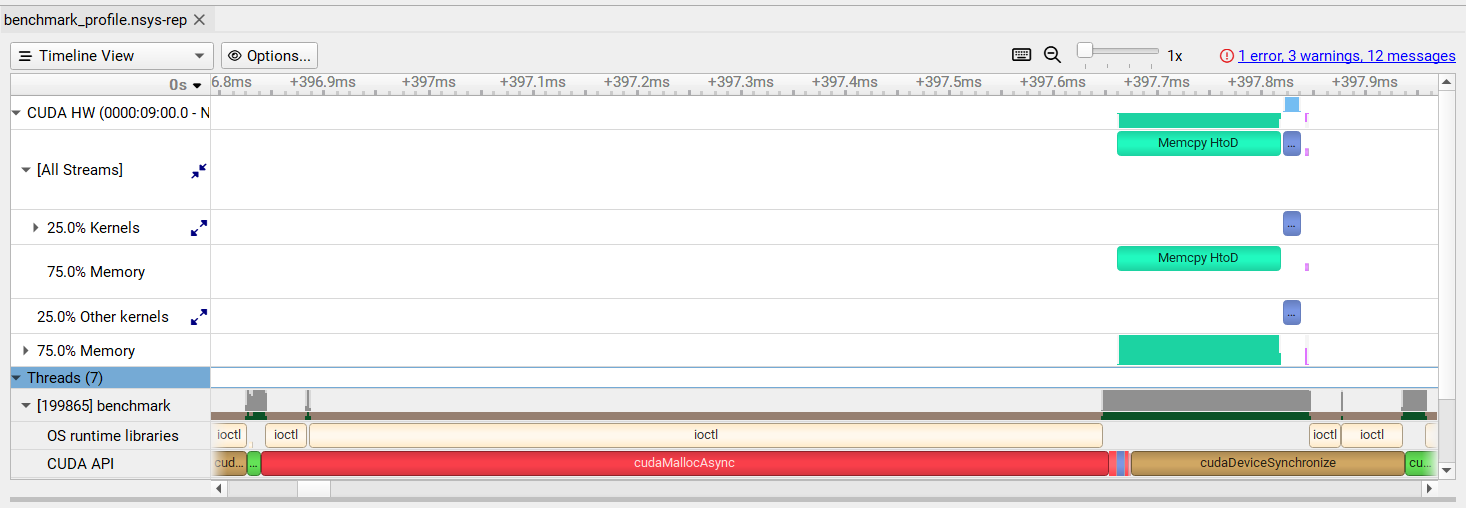

The second is `cudaStreamCreate`, shown in green (see the zoomed in image below). Since `M = 1`, we have only one stream creation as expected. 

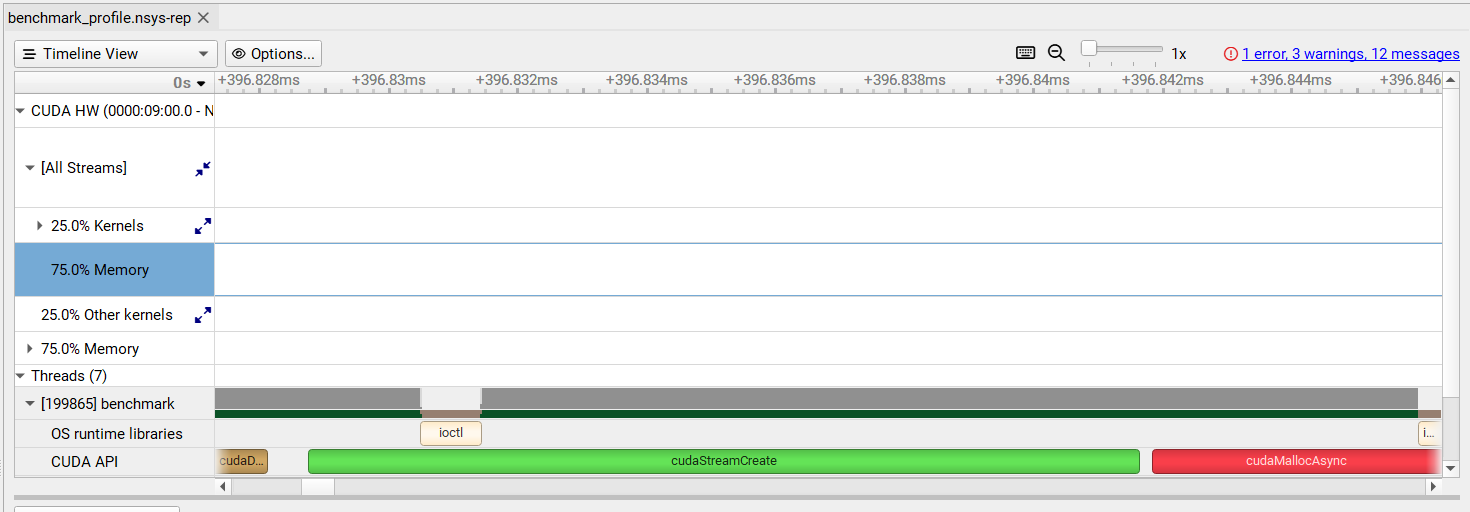

The third is `saxby`, which is the `global` matrix muliplication kernel. The fourth is `Memcpy HtoD` [CPU to GPU] (see the zoomed in image below).

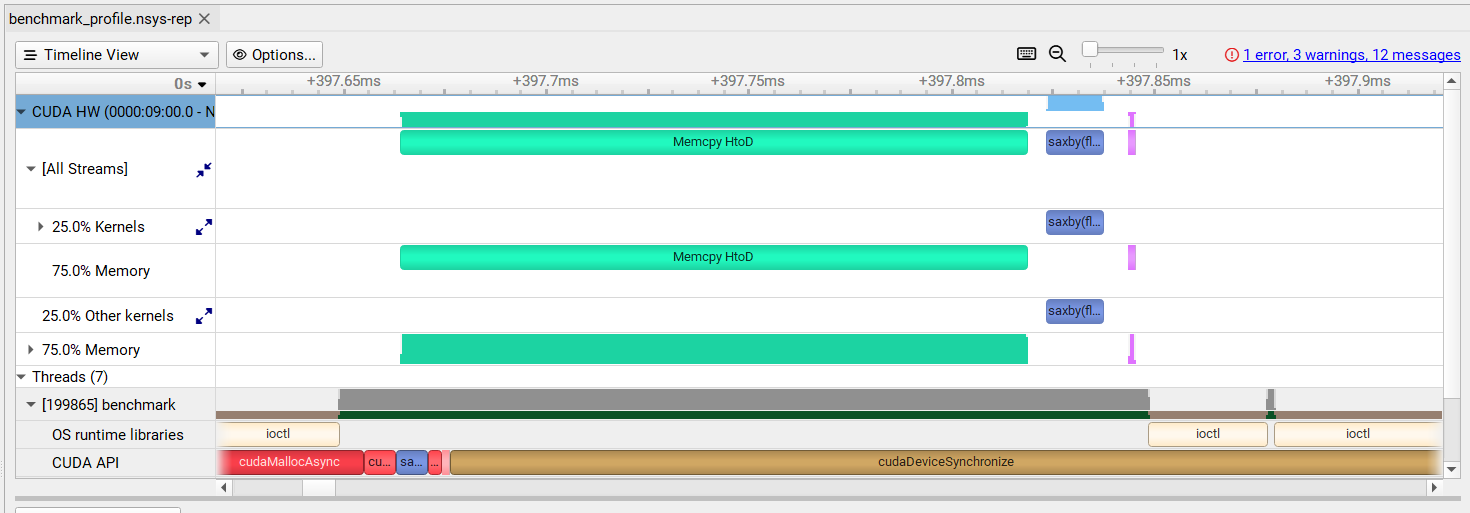

Now, we show the profile results when we have multiple streams. We choose `M = 4` arbitrarily.

### `M = 4`

The overall profile:

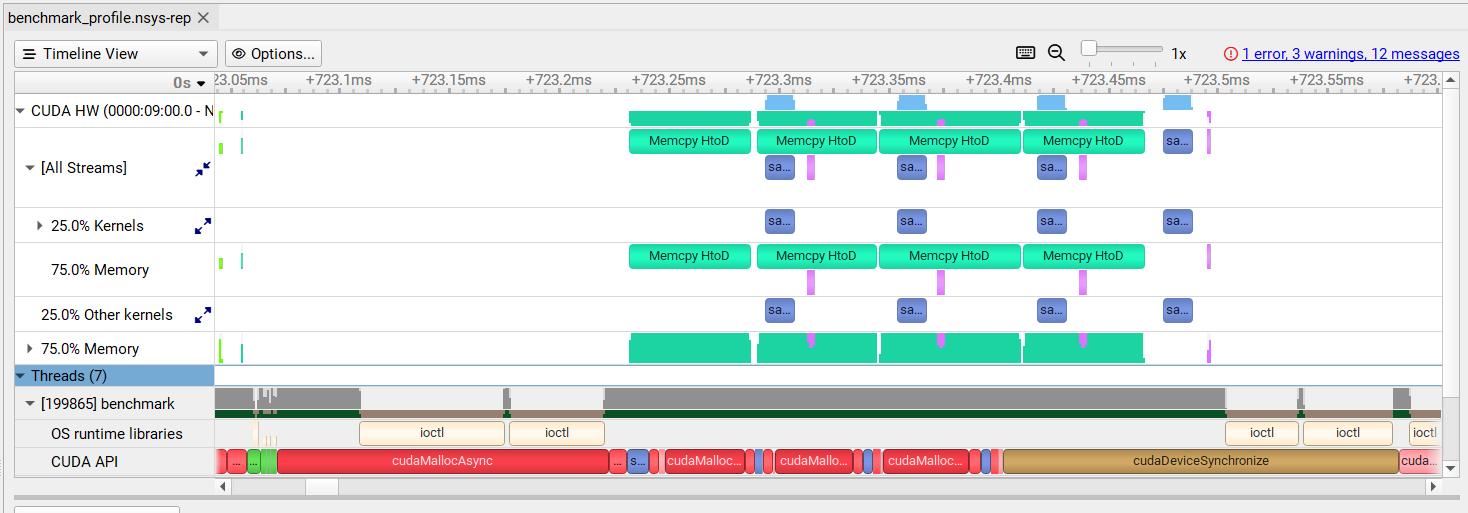

A zoomed profile over the `cudaStreamCreate`:

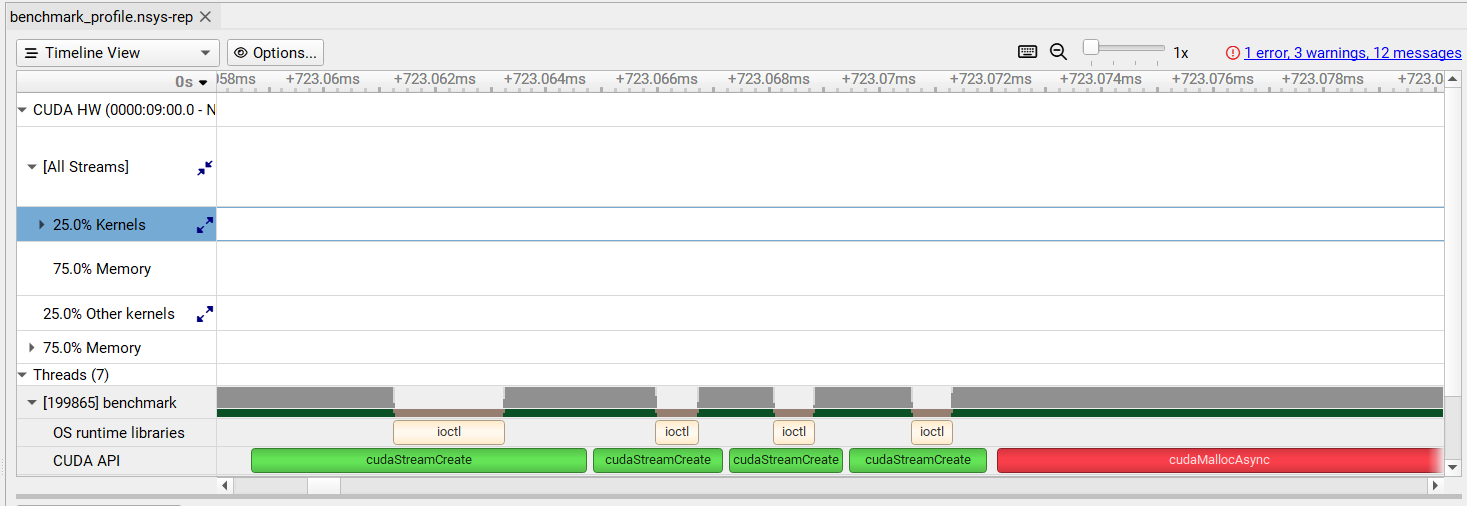

A zoomed profile over the `saxby` and `memcpyHtoD`:

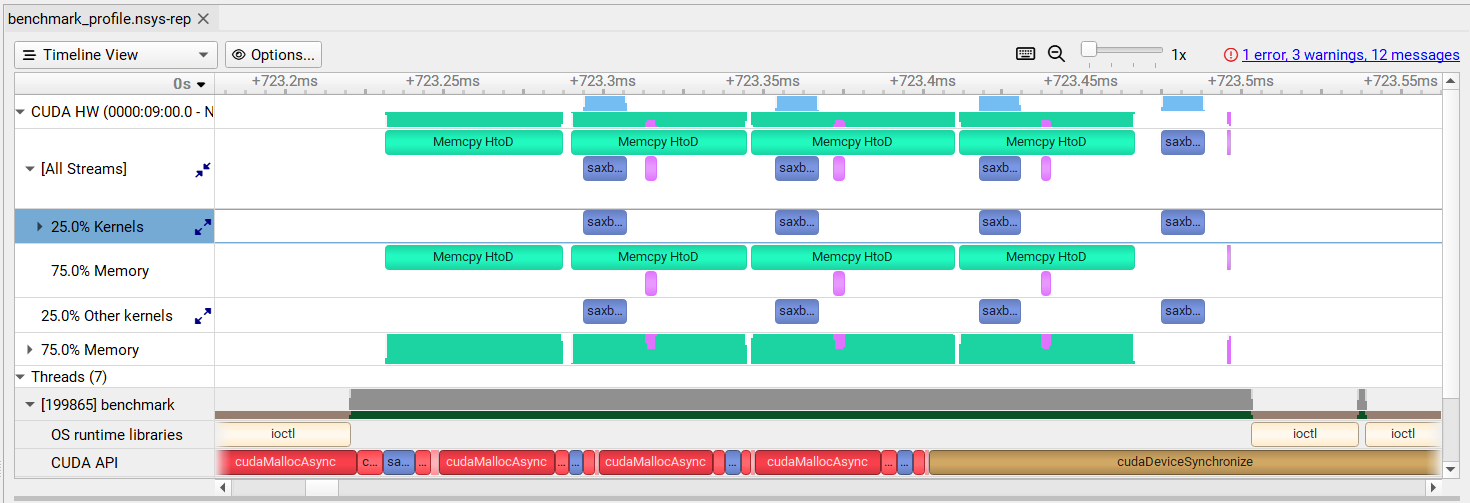

We make some interesting observations when comparing `M = 4` to `M = 1`:
1. The number of calls to `cudaStreamCreate` has increased to `M` consecutive calls.
2. `cudaMallocAsync` has broken into multiple chunks occuring concurrently with the `saxby` operations. This is expected since the call is `async`.
3. The number of calls to `memcpyHtoD` has increased to `M` consecutive calls. We did not expect calls of `memcpyHtoD` for different regions of the matrix (recall that each stream focuses on one distinct chunk of the matrix) to be consecutive, since the call is blocking and not `async`.
4. The `saxby` operations are occuring consecutive with `memcpyHtoD` calls. Specifically, each `saxby` operation occurs concurrently when when the next region of the matrix is being copied from host to device.

All of this is great news, since it indicates that the streams are working as intended. However, to see if we are getting noticable performance gains, we also profile `M = 8`.

### `M = 8`

The overall profile:

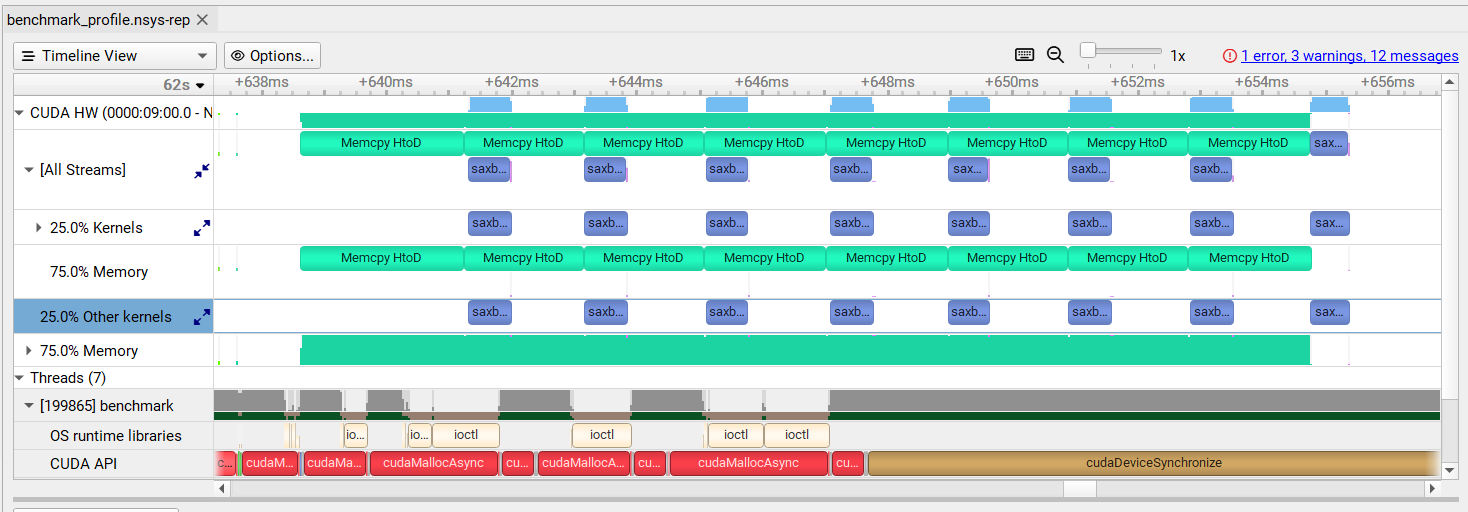

A zoomed profile over `cudaStreamCreate`:

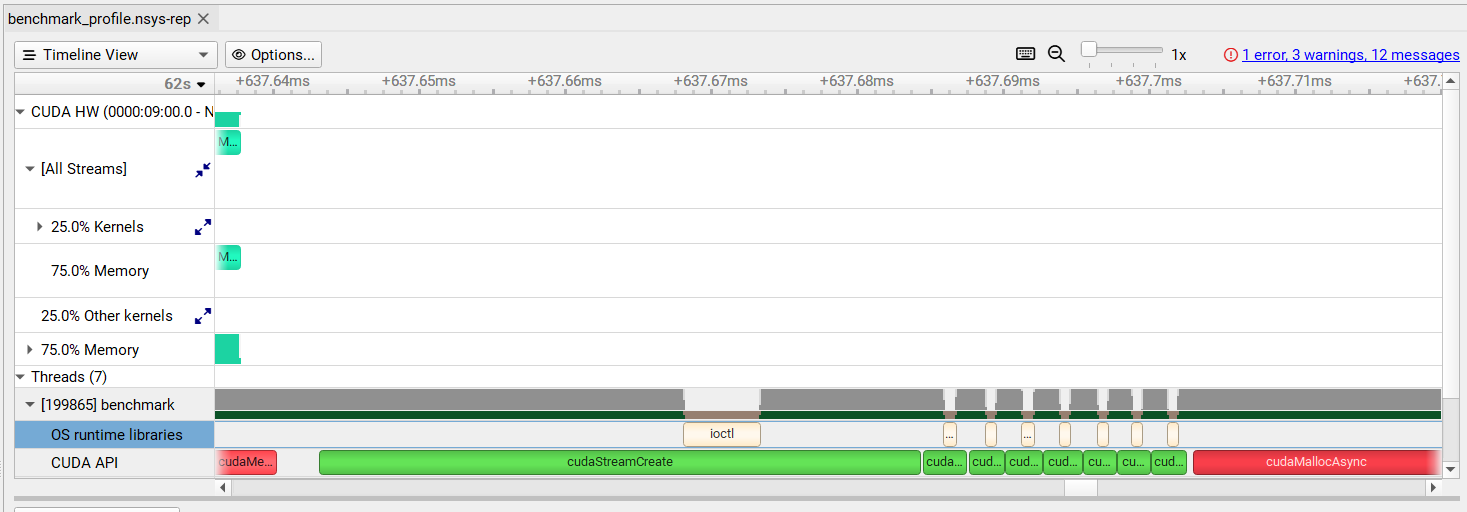

We make some *additional* observations when comparing `M = 8` to `M = 4`:
1. `cudaMallocAsync` has broken much nicer into multiple chunks occuring concurrently with the `saxby` operations.
2. `cudaStreamCreate` calls do not contribute significantly to the runtime of the overall matrix multiplication computation.
2. Each stream's `memcpyHtoD` takes much longer than the next stream's `saxby` operation.

From this, we can deduce that the bottleneck in performance is the relative time for `memcpyHtoD` as opposed to `saxby`. This bottleneck outweighs the benefits of using streams since the stream's `saxby` operation must wait longer than its own computation for `memcpy` to finish before it itself runs.

To explore this further, we can make the computation more extensive by increasing the dimensions of the matrix multiplication. We choose the extreme case where `N = K = 1e4` (recall that up till now `N = K = 1e3`).

### `M = 8` on a Larger Matrix

As expected, the stream computations are now longer than the two aforementioned *setup* calls. This would also indicate that we are getting good performance gains since we are no longer bottlenecked by setup.

The overall profile:

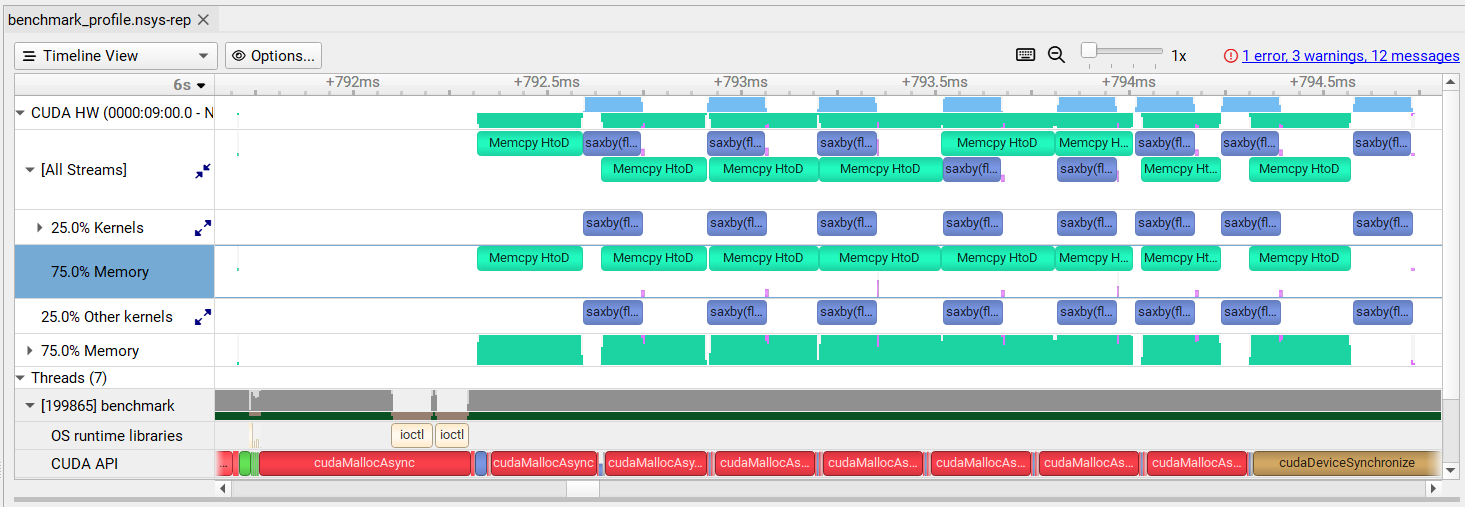

## Runtime Analysis

Now that we are confident that we are getting speedups, we should quantify them.

In [6]:
print(benchmark)

     i      n  m      k  reps                    multiplier       time_us  \
0    1   1000  1   1000    10  MatrixVectorStreamMultiplier    459.600006   
1    2   1000  2   1000    10  MatrixVectorStreamMultiplier    573.400024   
2    3   1000  3   1000    10  MatrixVectorStreamMultiplier    866.799988   
3    4   1000  4   1000    10  MatrixVectorStreamMultiplier    638.400024   
4    5   1000  5   1000    10  MatrixVectorStreamMultiplier    954.700012   
5    6   1000  6   1000    10  MatrixVectorStreamMultiplier   1123.000000   
6    7   1000  7   1000    10  MatrixVectorStreamMultiplier   1967.400024   
7    8   1000  8   1000    10  MatrixVectorStreamMultiplier   2246.000000   
8    9   1000  1  10000    10  MatrixVectorStreamMultiplier   3929.699951   
9   10   1000  2  10000    10  MatrixVectorStreamMultiplier   3659.000000   
10  11   1000  3  10000    10  MatrixVectorStreamMultiplier   3636.100098   
11  12   1000  4  10000    10  MatrixVectorStreamMultiplier   3793.600098   